# We will learn pandas library which is very useful for working with tabular data that you  would normally work with in Excel

We also will use `sklearn`'s machine learning algorithms to do some regression  
http://scikit-learn.org/stable/supervised_learning.html

In [13]:
import os
import glob
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline


## Read in all of the data from the Nov18,2017 Asilomar trials

In [14]:
glob.glob('/home/bob/datasets/asilomar_data/nov18_2017/csv/*.csv')
df = pd.DataFrame.from_csv('/home/bob/datasets/asilomar_data/nov18_2017/csv/output41.csv')

In [15]:
df.head(1)
df.columns

Index([u'Time', u'Box Detected', u'Box Estimated', u'Distance Lidar',
       u'Distance Estimated', u'Kalman Error', u'Kalman Gain', u'State',
       u'Measurement Cov'],
      dtype='object')

In [16]:

def extract_bb_lidar_from_csv(csv_file):
    df = pd.DataFrame.from_csv(csv_file)
    bboxes_detected = []
    lidar_distances = []
    if 'Box Detected' in df.columns and 'Distance Lidar' in df.columns:
        for box_detected, lidar_distance in zip(df['Box Detected'], df['Distance Lidar']):
            bbox = [int(s) for s in box_detected.replace('[','').replace(']','').replace(',','').split(' ') if len(s)>0]
            bboxes_detected.append(np.array(bbox))
            lidar_distances.append(float(lidar_distance))
        bb_series = pd.Series(data=bboxes_detected)
        lidar_series = pd.Series(data=lidar_distances)
        output_df = pd.DataFrame(columns=['bbox', 'lidar'])
        output_df['bbox'] = bb_series
        output_df['lidar'] = lidar_series
        return output_df

def clean_data(dataframe):
    """
    remove bbox [-1, -1, -1, -1] entries
    remove lidar 0.0 entries
    """
    is_good = []
    for bb, dist in zip(dataframe['bbox'], dataframe['lidar']) :
        if bb is not None and dist is not None:
            if (bb == np.array([-1,-1,-1,-1])).all() or not dist > 0:
                is_good.append(False)
            else:
                is_good.append(True)
        else:
            is_good.append(False)
    return dataframe[is_good].copy()

def normalize_data(dataframe):
    pass

In [17]:
# get all of the .csv filenames
all_csv = glob.glob('/home/bob/datasets/asilomar_data/nov18_2017/csv/*.csv')
csv_files = []
for csv in all_csv:
    # ignore the _t files
    if '_t.csv' not in csv:
        csv_files.append(csv)
dataframes = []
for csv_file in csv_files:
    df_unclean = extract_bb_lidar_from_csv(csv_file=csv_file)
    if df_unclean is None:
        continue
    df_clean = clean_data(dataframe=df_unclean)
    dataframes.append(df_clean)
#     dataframes.append(df_unclean)

In [18]:
# now combine all of the dataframes into one by simple using pd.concat()
df_concat = pd.concat(dataframes)
# format as discrete columns for each bbox value
df_train = pd.DataFrame(columns=['u', 'v', 'w', 'h', 'distance'])
bboxes = df_concat['bbox'].values
bboxes = np.concatenate(bboxes, axis=0).reshape(len(bboxes),4) # reshape bboxes data into a single numpy array
df_train['u'] = bboxes[:,0]
df_train['v'] = bboxes[:,1]
df_train['w'] = bboxes[:,2]
df_train['h'] = bboxes[:,3]
df_train['distance'] = df_concat['lidar'].values

## Now that we've combine all of our data, let's do an Expoloratory Data Analysis (EDA)

## Firstly, let's plot a histogram of the lidar distances

In [19]:
df_train.describe()

,u,v,w,h,distance
count,15841.000000,15841.000000,15841.00000,15841.000000,15841.000000
mean,250.152452,257.231235,355.74768,341.913389,54.681751
std,66.792629,9.236306,65.08083,58.459665,27.591418
min,0.000000,202.000000,110.00000,255.000000,10.964567
25%,228.000000,252.000000,326.00000,300.000000,29.179791
50%,266.000000,256.000000,345.00000,318.000000,55.360894
75%,285.000000,263.000000,378.00000,367.000000,79.852365
max,493.000000,300.000000,640.00000,480.000000,131.820870


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbdb511090>]], dtype=object)

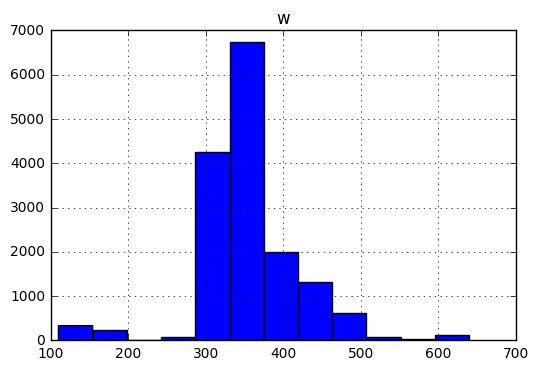

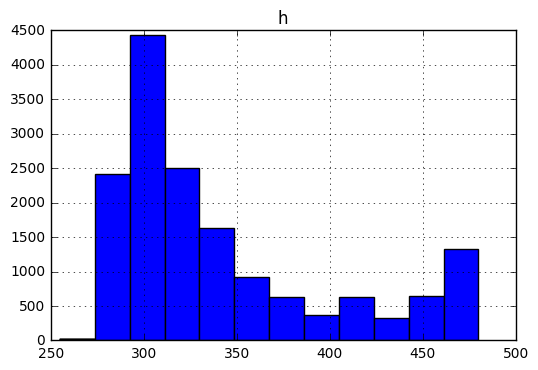

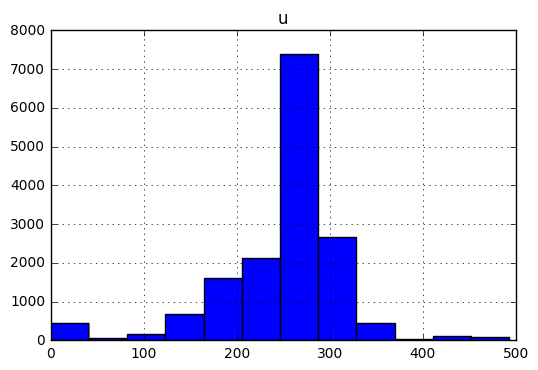

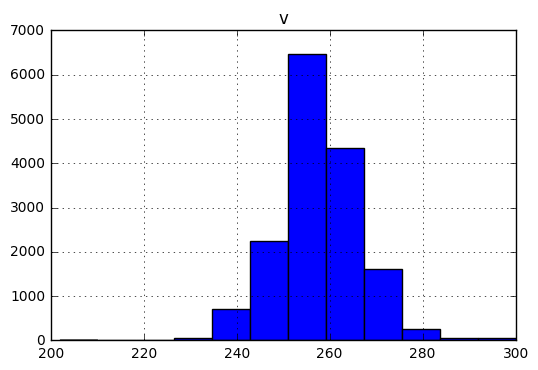

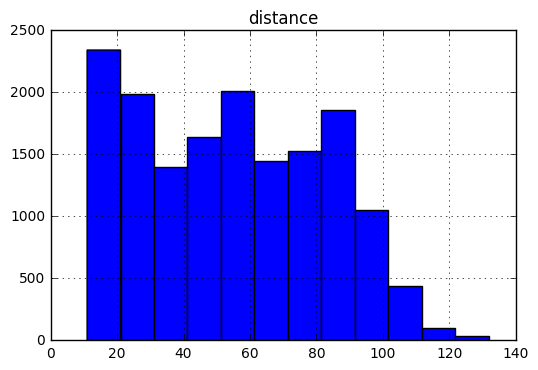

In [20]:
# let's bin our distances into 10ft
num_bins = int((df_train['distance'].max() - df_train['distance'].min()) // 10)
# num_bins = int((df_train['distance'].max() - df_train['distance'].min()) // 1)
df_train.hist(column='w',bins=num_bins)
df_train.hist(column='h',bins=num_bins)
df_train.hist(column='u',bins=num_bins)
df_train.hist(column='v',bins=num_bins)
df_train.hist(column='distance',bins=num_bins)

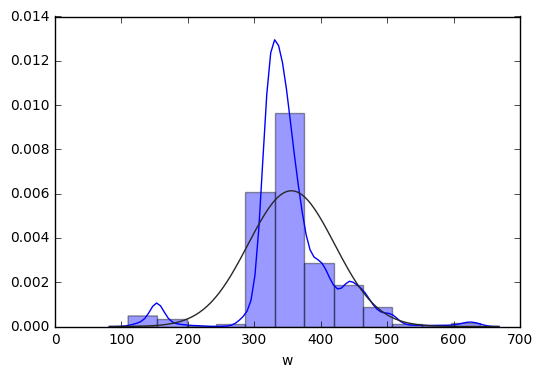

In [65]:
# Let's cut off the histograms for h,w,x,y between 200 ~ 500
def trim(dataframe, column, lower, upper):
    dataframe = dataframe.copy()
    dataframe = dataframe[dataframe[column] < upper]
    dataframe = dataframe[dataframe[column] > lower]    
    return dataframe
# trim(df_train, column='w', lower=300, upper= 500).hist(column='w',bins=num_bins)
sns.distplot(df_train['w'], bins=num_bins, fit=st.norm)
# trim(df_train, column='h', lower=300, upper= 500).hist(column='h',bins=num_bins)
# trim(df_train, column='u', lower=100, upper= 350).hist(column='u',bins=num_bins)
# trim(df_train, column='v', lower=100, upper= 350).hist(column='v',bins=num_bins)
# trim(df_train, column='distance', lower=5, upper= 140).hist(column='distance',bins=num_bins)

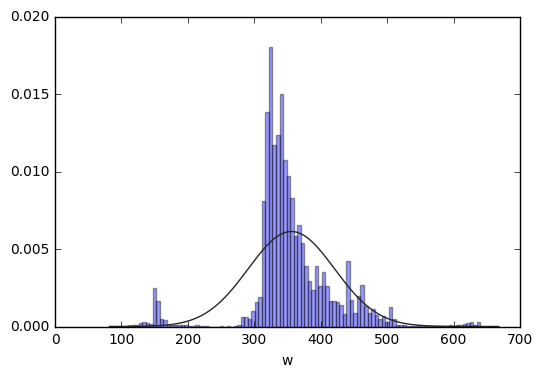

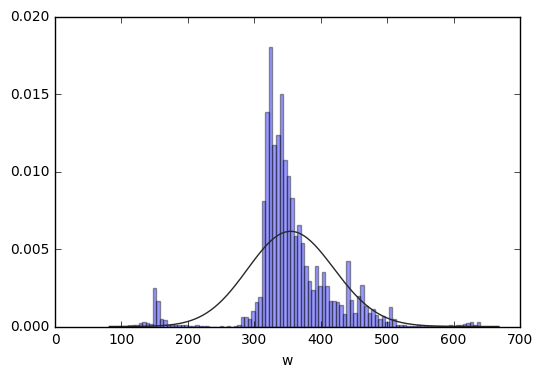

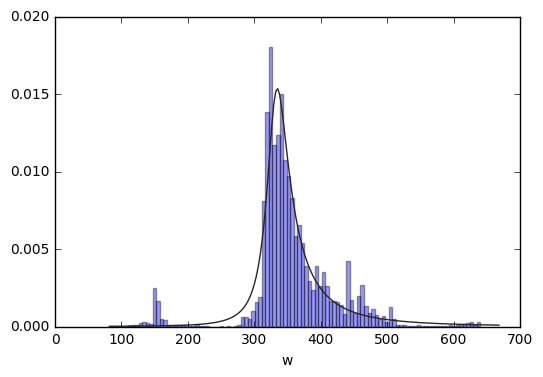

In [97]:
# log_widths = np.log1p(df_train['w'].values)
# df_logw = pd.DataFrame(columns=['w'],data=log_widths)
sns.distplot(df_train['w'], bins=100, fit=st.norm, kde=False)
plt.show()
sns.distplot(df_train['w'], bins=100, fit=st.lognorm, kde=False)
plt.show()
sns.distplot(df_train['w'], bins=100, fit=st.johnsonsu, kde=False)
plt.show()

### Looks like the Johnson SU fits best, let's transform to that!

In [ ]:
def johnson(y):
    gamma, eta, epsilon, lbda = st.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda
def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon
yt, g, et, ep, l = johnson(df_train['w'].copy())
yt2 = johnson_inverse(yt, g, et, ep, l)
df_transformed = pd.DataFrame(columns=['w'],data=yt) # TODO: do necessary transforms for other columns
# plt.subplot(131)
plt.title('before transformation')
sns.distplot(df_train['w'], bins=100, fit=st.norm, kde=False)
plt.show()
# plt.subplot(132)
plt.title('after transformation')
sns.distplot(df_transformed['w'], bins=100, fit=st.norm, kde=False)
plt.show()
# plt.subplot(133)
plt.title('inverse transformation')
sns.distplot(yt2, bins=100, fit=st.norm, kde=False)
plt.show()

# TODO: more EDA!
Perhaps:
* correllation
* co-dependence (does width depend on height etc.)
* others...

In [32]:
df_train
X_train, X_test, y_train, y_test = make_train_test_data_4d(dataframe=df_train)

In [26]:
print('we have {} Train and {} Test samples'.format(len(X_train), len(X_test)))

we have 11088 Train and 4753 Test samples


In [27]:
model = SVR(C=20)
# model = LinearRegression()

results = train_test(model, X_train, y_train, X_test, y_test)

In [28]:
results_small = train_test(model, X_train_4d, y_train_4d, X_test_4d, y_test_4d) # smaller batch from earlier

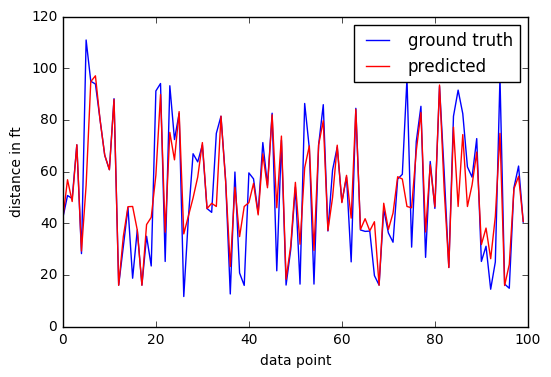

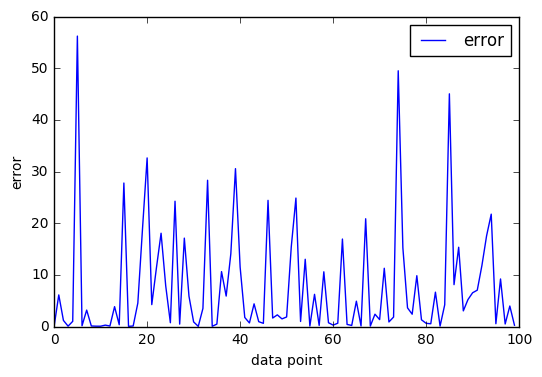

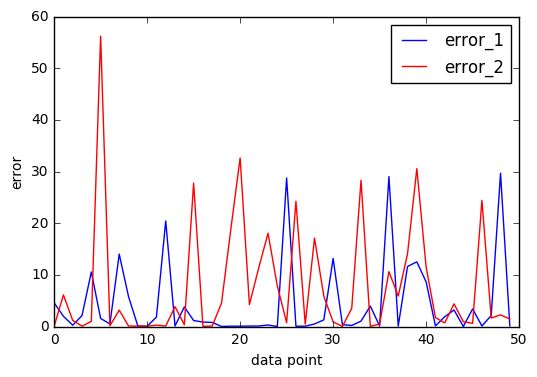

In [29]:
plot_predictions(dataframe=results, start_idx=0, end_idx=100)
plot_errors(dataframe=results, start_idx=0, end_idx=100)
compare_errors(dataframe_1=results_small, dataframe_2=results, start_idx=0, end_idx=50)

# TODO: Normalize data, Try Neural Network